In [9]:
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer

# Channel Simulation
here starts the actual channel simulator code.

In [ ]:
modify_t0 = 1e0
modify_zn = 1e0
modify_h = 1e0
modify_au = 1e-12

dt = 1e-12  # 1e-12

test_verbose = False

cs = ChannelSimulator(m_qam=16,
                      num_symbols=512,
                      normalization_factor=1e-3 * modify_au,
                      dt=dt,
                      channel_func=SplitStepFourier(
                          alpha=0,
                          b2=-20e-27,
                          gamma=0.003,
                          t0=125e-12 * modify_t0,
                          dt=dt,
                          z_n=1 * modify_zn,
                          h=500 * modify_h
                      ),
                      verbose=True)

np.set_printoptions(threshold=250)

In [10]:
cs.step0_gen_msg()  # generate message


_______________________________________________
message before channel - len=2048
[[0 1 0 1]
 [1 0 0 1]
 [0 1 1 0]
 ...
 [1 1 1 1]
 [0 1 1 1]
 [0 1 1 0]]


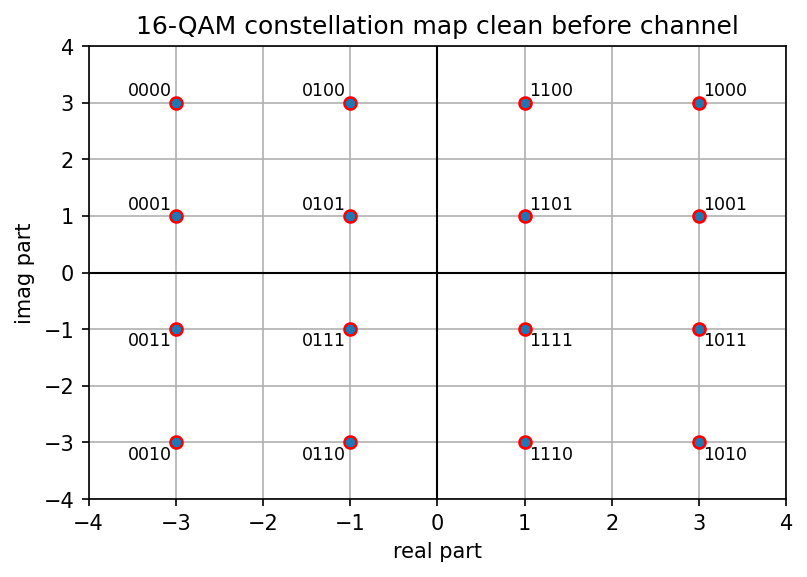

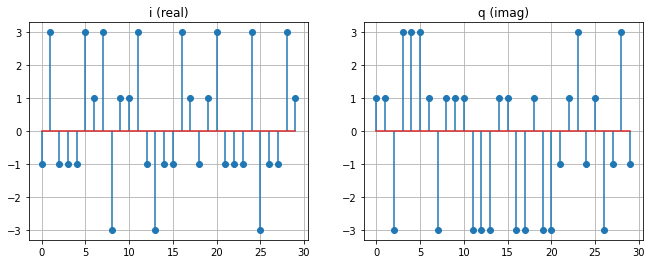

num of symbols = 512


In [11]:
cs.step1_modulate()  # modulate

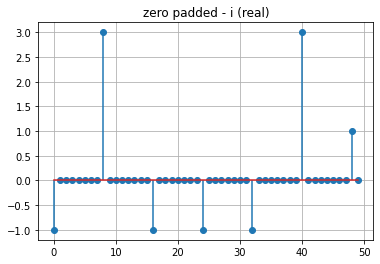

vec length = 4096, over_sampling period = 8


In [12]:
cs.step2_over_sample()  # over sample

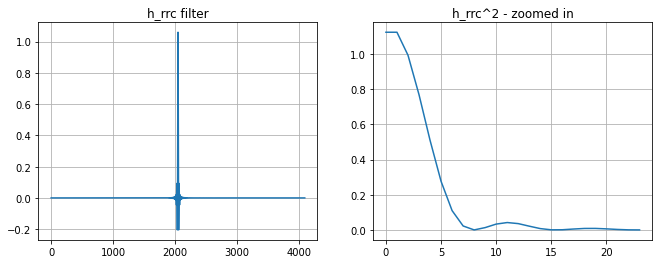

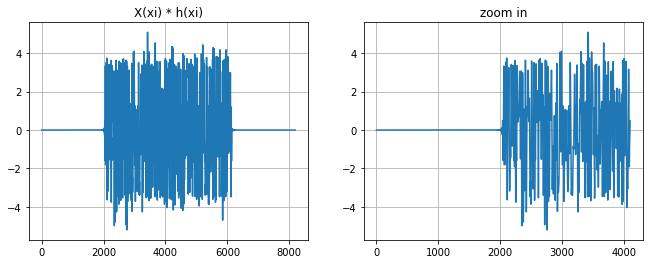

filter len = 4097, signal len = 8192


In [13]:
cs.step3_pulse_shaping()  # pulse shaping

xi ∈ [-1570.41:1570.80] GHz ,	 N_xi   (=M) = 8192
t  ∈ [-4096.00:4095.00] ps    ,	 N_time (=D) = 8192
BW = 1570.80 GHz


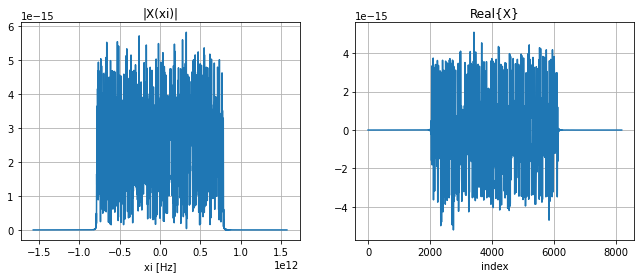

signal len = 8192


In [14]:
cs.step4_pre_equalize()  # pre equalize (equalize before inft)

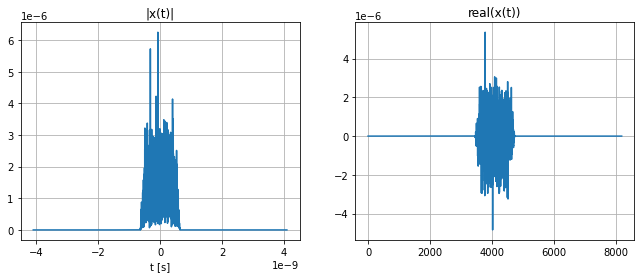

length of INFT(x) = 8192
signal power = 5.52e-05
signal bw = [-6.30e-10:6.36e-10]


In [15]:
cs.step5_inft()  # inft

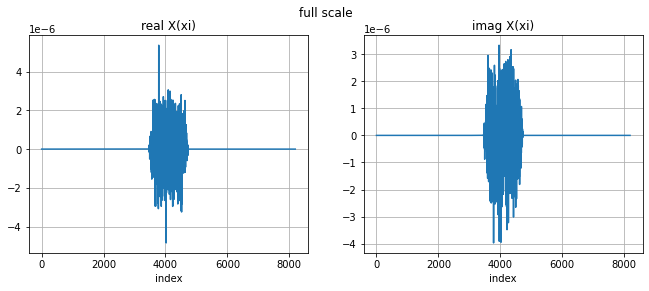

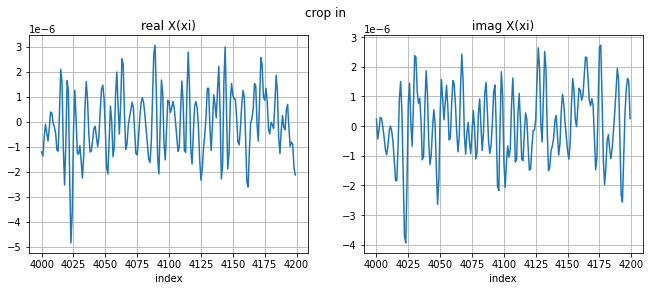

In [16]:
# plot before channel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
fig.suptitle('full scale')
Visualizer.my_plot(np.real(cs.x[5]), name=f'real X(xi)', xlabel='index', ax=ax1, hold=1)
Visualizer.my_plot(np.imag(cs.x[5]), name=f'imag X(xi)', xlabel='index', ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
fig.suptitle('crop in')
zm = range(4000, 4200)
Visualizer.my_plot(zm, np.real(cs.x[5][zm]), name=f'real X(xi)', xlabel='index', ax=ax1, hold=1)
Visualizer.my_plot(zm, np.imag(cs.x[5][zm]), name=f'imag X(xi)', xlabel='index', ax=ax2)

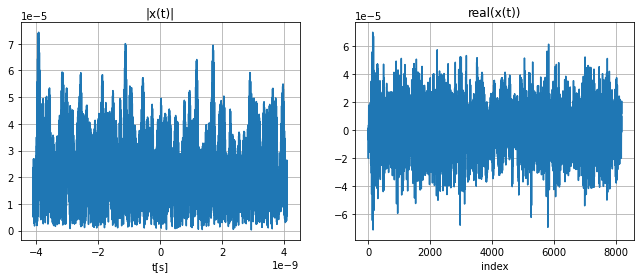

In [17]:
cs.step6_channel()  # channel (ssf)

In [ ]:
# plot after channel
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
fig.suptitle('full scale')
Visualizer.my_plot(np.real(cs.x[6]), name=f'real X(xi)', xlabel='index', ax=ax1, hold=1)
Visualizer.my_plot(np.imag(cs.x[6]), name=f'imag X(xi)', xlabel='index', ax=ax2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
fig.suptitle('crop in')
zm = range(4000, 4200)
Visualizer.my_plot(zm, np.real(cs.x[6][zm]), name=f'real X(xi)', xlabel='index', ax=ax1, hold=1)
Visualizer.my_plot(zm, np.imag(cs.x[6][zm]), name=f'imag X(xi)', xlabel='index', ax=ax2)

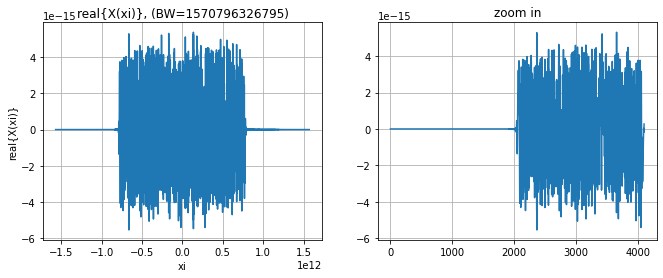

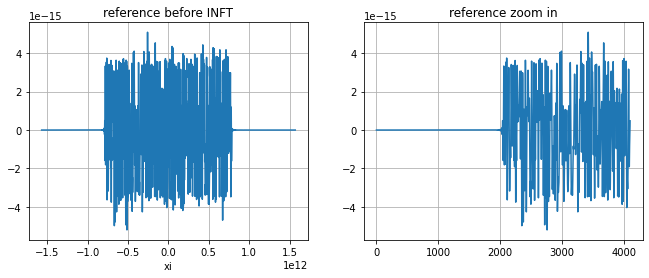

In [18]:
# cs.x[6] *= 1e11
cs.step7_nft()  # nft

In [19]:
cs.step8_equalize()  # equalizer

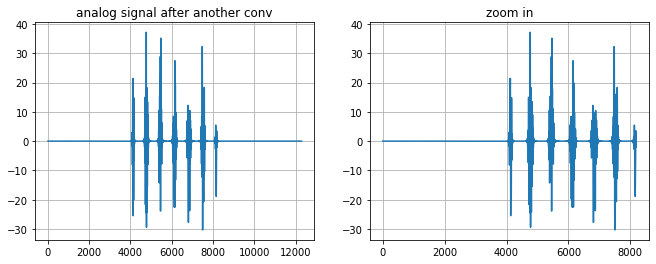

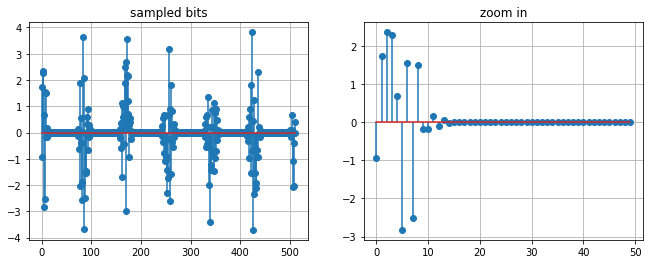

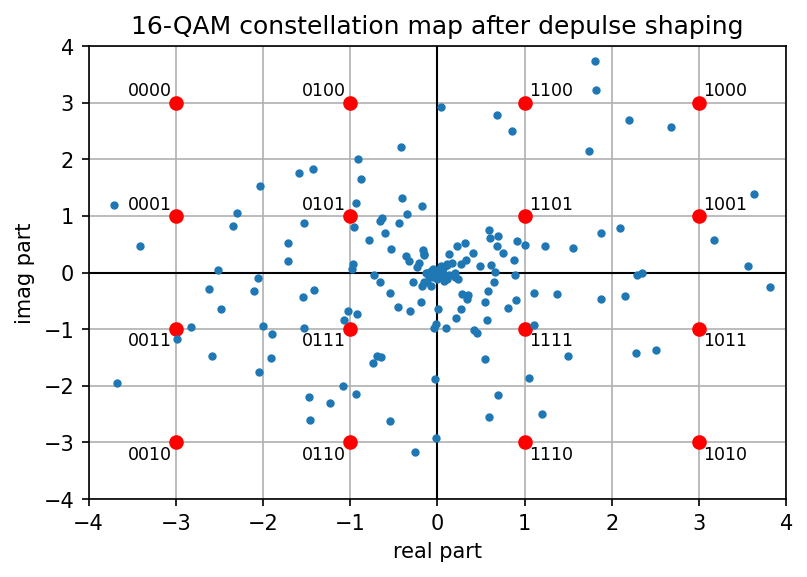

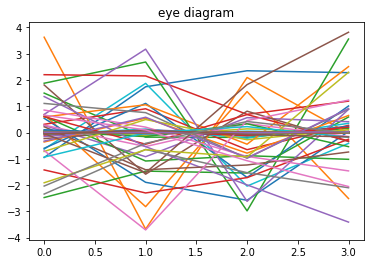

num of sampled symbols = 512 


In [20]:
cs.step9_match_filter()  # match filter

In [21]:
cs.step10_demodulate()  # demod()


_______________________________________________
message after channel - len=2048
[[0 1 0 1]
 [1 1 0 0]
 [1 0 1 1]
 ...
 [0 1 0 1]
 [1 1 1 1]
 [0 1 1 0]]


In [22]:
ber, num_errors = cs.evaluate()

ber = 0.46533203125 = 953/2048
